# Стохастический анализ (2024)
# Домашнее Задание 1 (программная часть)


In [24]:
#all imports here, please
import numpy as np
import sklearn.linear_model as sklin

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
import pickle


## Часть 1: Оценка параметров в модели Блэка-Шоулза (20 баллов)

В одной из первых классических финансовых моделей цены акций моделируются с помощью процесса геометрического Броуновского движения (GBM). Пусть $(W_t)_{t \in \mathbb{R}_+}$ -- Винеровский процесс, тогда процесс геометрического Броуновского движения задаётся как

$$
X_t = X_0 e^{(\mu-\sigma^2/2)t + \sigma W_t},
$$

$\mu$ -- параметр сноса (связан с безрисковой процентной ставкой),  $\sigma$ -- параметр волатильности (показывающий насколько интенсивно цена может колебаться, связан с активностью инвесторов). Ваша задача в этом упражнении построить первую модель для оценки параметров по имеющейся дискретной реализации процесса.

### Вывод формул для параметров

Пусть даны $X_0,X_{t_1}..,X_{t_n}$ -- часть траектории процесса, мы хотим подогнать параметры $\mu,\sigma$ в предположении, что наблюдения пришли из геометрического Броуновского движения. Обычная регрессия в данном случае нам не подойдёт, так как мы имеем дело с нелинейной моделью и наблюдения $X_i$ зависимы. Но можно выписать функцию правдоподобия, если вспомнить, что логарифмы
$$
    \ln \frac{X_t}{X_{t-1}}
$$
независимы.

#### Функция правдоподобия

Пусть даны $t_0=0,t_1,..,t_n$ и $X_0,X_1,..,X_n$ (например, данные собранные на бирже). Выпишите функцию правдоподобия $L(\mu,\sigma)$ для модели, возьмите в конце логарифм, так как с ним будет удобнее работать.

$L(μ, σ) = \sum_{i = 1}^n \sigma(W_t - W_{t-1}) + \mu - \frac{\sigma^2}{2}$


#### Вычисление производных

Вычислите производные функции $\ln L(\mu,\sigma)$.

ВАШЕ РЕШЕНИЕ
Отметим что

$$ ln(X_{t_i}) = ln(X_0) + (\mu - \frac{\sigma^2}{2})t_{i} + \sigma W_{t_i} $$
$$ x_i := ln(X_{t_i}) - ln(X_{t_{i-1}})  \sim  N((\mu - \frac{\sigma^2}{2})(t_i - t_{i-1}), \sigma^2(t_i - t_{i-1})) $$

Как известно, оценки ММП устойчивы относительно монотонного преобразования, поэтому сделаем замену:

$$ \alpha = (\mu - \frac{\sigma^2}{2})(t_i - t_{i-1}) $$
$$ \beta^2 = \sigma^2(t_i - t_{i-1}) $$
И получим:
$$ x_i \sim N(\alpha, \beta^2) $$

Тогда задача по нахождению производных сильно упрощается:
$x_i$ имеют плотность
$$p_{x_i} =  \frac{1}{\sqrt{(2\pi\beta^2)}} \cdot e^{-\frac{(x_i-\alpha)^2}{2\beta^2}}$$

Выпишем правдоподобие и его логарифм:
$$\mathcal{L}(\alpha, \beta | x) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\beta^2}} e^{-\frac{(x_i - \alpha)^2}{2\beta^2}}$$

$$\ln(\mathcal{L}(\alpha, \beta | x)) = -\frac{n}{2} \ln(2\pi\beta^2) - \frac{1}{2\beta^2} \sum_{i=1}^{n} (x_i - \alpha)^2$$

$$
\partial_\alpha \ln L = \frac{\partial}{\partial \alpha} \ln(\mathcal{L}(\alpha, \beta | x)) = \frac{1}{\beta^2} \sum_{i=1}^{n} (x_i - \alpha)
$$

$$
\frac{\partial}{\partial \beta} \log(\mathcal{L}(\alpha, \beta | x)) = -\frac{n}{\beta} + \frac{1}{\beta^3} \sum_{i=1}^{n} (x_i - \alpha)^2
$$

#### Запись формул для $\mu,\sigma$

Найдите $\mu,\sigma$, приравняв производные к нулю (в этих точках функция действительно будет иметь максимум, проверяется вычислением матрицы Гессе, но здесь это делать не нужно).

ВАШЕ РЕШЕНИЕ

Приравняв записанные выше производные к нулю, получим:



$$ \frac{1}{\beta^2} \sum_{i=1}^{n} (x_i - \alpha) \rArr \hat{\alpha} = \bar{x} $$

$$ -\frac{n}{\beta} + \frac{1}{\beta^3} \sum_{i=1}^{n} (x_i - \hat{\alpha})^2 = 0 \rArr \hat{\beta} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2}$$

Вспоминаем, что мы сделали замену параметров:

$$ \hat{\sigma^2} = \frac{\hat{\beta^2}}{\Delta t_i} = \frac{1}{\Delta t_i} \cdot \frac{1}{n}  \sum_{i=1}^{n} (x_i - \bar{x})^2$$

$$
\hat{\mu} = \frac{\bar{x}}{\Delta t_i} + \frac{\hat{\sigma^2}}{2}
$$

Позже можно увидеть, что $\Delta t_i$ в наших данных одинаковые, а значит их можно унифицировать и в формулах оценок

### Воплощение в коде

Теперь имплементируйте модель оценки, используйте для основы код ниже. Нам также понадобится код для симуляции Винеровского процесса.

In [53]:
def simulateWienerProcess(x0,ts,Ntraj):
    '''
    Simulates trajectories of Wiener process
    Input
    float x0 -- initial value
    float[] ts -- times
    int Ntraj -- number of trajectories to simulate
    Returns
    float[] of shape (Ntraj,len(ts))
    '''
    #для определения размерности
    try:
        d = x0.shape[0]
    except:
        d = 1

    xs = np.zeros([Ntraj, d, len(ts)]) #здесь не матрица, а прямо тензор, здесь несколько размерностей, но крайний вктор W0 = 0
    xs[..., 0] = x0 # эллипсис

    #генерируемм тензор шумов
    for kk in np.arange(1, len(ts)):
        noises = np.random.standard_normal(size = (Ntraj, d)) #можно без холецкого
        xs[..., kk] = xs[..., kk-1] + noises*np.sqrt(ts[kk] - ts[kk-1])

    return xs


class GBMModel:
    '''
        Implements Geometric Brownian Motion, allowing for parameter estimation and simulations
    '''

    def __init__(self, mu=0,sigma=1):
        '''
        Input
        float mu -- drift parameter (if pre-defined)
        float sigma -- volatility (if pre-defined)
        '''
        self.mu=mu
        self.sigma=sigma
        self.interval_low = 0
        self.interval_high = 0


    def fit(self, xs, ts):
        '''
        Fits the parameters to the given time series
        Input
        float[] xs -- observations
        float[] ts -- times (same shape as xs)
        '''

        #YOUR CODE
        #self.sigma=???
        #self.mu=???
        dt = np.diff(ts)
        log_returns = np.log(xs[1:] / xs[:-1])
        self.mu = np.ones([1])* np.mean(log_returns / dt) + 0.5 * np.var(log_returns / dt)
        self.sigma = np.ones([1])* np.std(log_returns / dt)



    def simulate(self,x0,ts,Ntraj,confLevel=0):
        '''
        Simulates trajectories of GBM with set mu and sigma
        Input
        float x0 -- initial price
        float[] ts -- times
        int Ntraj -- number of trajectories to simulate
        float confLevel -- confidence level, set to non-zero if confInterval is needed
        Returns
        float[] of shape (Ntraj,len(ts)) , trajectories
        if confLevel!=0,
        then returns  float[] (Ntraj,len(ts)), float[] (len(ts),), float[] (len(ts),)
        which are trajectories, confidenceLow, confidenceHigh
        '''
        try:
            wienProc = simulateWienerProcess(np.zeros(x0.shape, ts - ts[0], Ntraj))


        except:
            wienProc = simulateWienerProcess(0, ts - ts[0], Ntraj)


        #YOUR CODE
        #Use simulateWienerProcess to simulateW trajectories of Wiener process
        #Based on that, compute GBM
        #For confidence intervals use the exponentiated gaussian intervals of (mu-sigma^2/2)t + sigma W_t
        self.wienTrajs = simulateWienerProcess(np.zeros(x0.shape[0]),ts-ts[0],Ntraj)
        self.gbmTrajs = x0[None,:,None]*np.exp((self.mu-0.5*self.sigma**2)[None, :, None]*ts[None,None,:] + self.sigma[None, :, None]*self.wienTrajs)

        xs = x0[None,:,None]*np.exp((self.mu-0.5*self.sigma**2)[None, :, None]*ts[None,None,:] + self.sigma[None, :, None]* wienProc)
        #xs = x0*np.exp((self.mu - self.sigma**2/2)[None, :, None]*ts[None, None, :] + self.sigma[None, :, None] * wienProc)
        #[Ntraj, d, T]

        #если нужно изобразить с ненулевым значением cl доверительный интервал
        if confLevel > 0:
            mu_log = (self.mu - self.sigma**2*0.5)*ts + np.log(x0)
            std_log = np.sqrt(self.sigma**2*ts)
            self.interval_low = np.exp(mu_log - norm.ppf(1 - confLevel/2)*std_log)
            self.interval_high = np.exp(mu_log + norm.ppf(1 - confLevel/2)*std_log)

        return xs

    def predict(self,x0,ts, numPreds):
        '''
        Makes a prediction based on the fact that at ts[0] the process value equals x0
        Input
        float x0 -- initial price
        float[] ts -- times for predictions
        int numPreds -- number of predictions to make
        Returns
        float[] preds, float[] confIntLows, float[] confIntHigh
        predictions (len(ts)), confIntLows (len(ts)), confIntHighs (len(ts))
        '''

        #YOUR CODE
        preds = x0*np.exp(self.mu*(ts[1:numPreds] - ts[0]))

        mu_pred = (self.mu - (self.sigma**2)*0.5)*(ts[1:numPreds] - ts[0]) + np.log(x0)
        std_pred = self.sigma*np.sqrt(ts[1:numPreds] - ts[0])

        confLow = np.exp(mu_pred - 1.96*std_pred)
        confHigh = np.exp(mu_pred + 1.96*std_pred)

        return preds, confLow, confHigh


В качестве теста, попробуйте нарисовать траектории Винеровского процесса и траектории геометрического броуновского движения для данных ниже.

In [54]:
#testing
a=0
b=3
Nt=100
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

mu=0.10 *np.ones([1]) #безрискоавя ставка 10%
sigma=0.22*np.ones([1]) #волатильность 22%
Ntraj=10
x0=15*np.ones([1]) #стартовая цена 15

gbm = GBMModel(mu,sigma)
gbmTrajs = gbm.simulate(x0,ts,Ntraj)
wienTrajs = simulateWienerProcess(x0,ts,Ntraj)

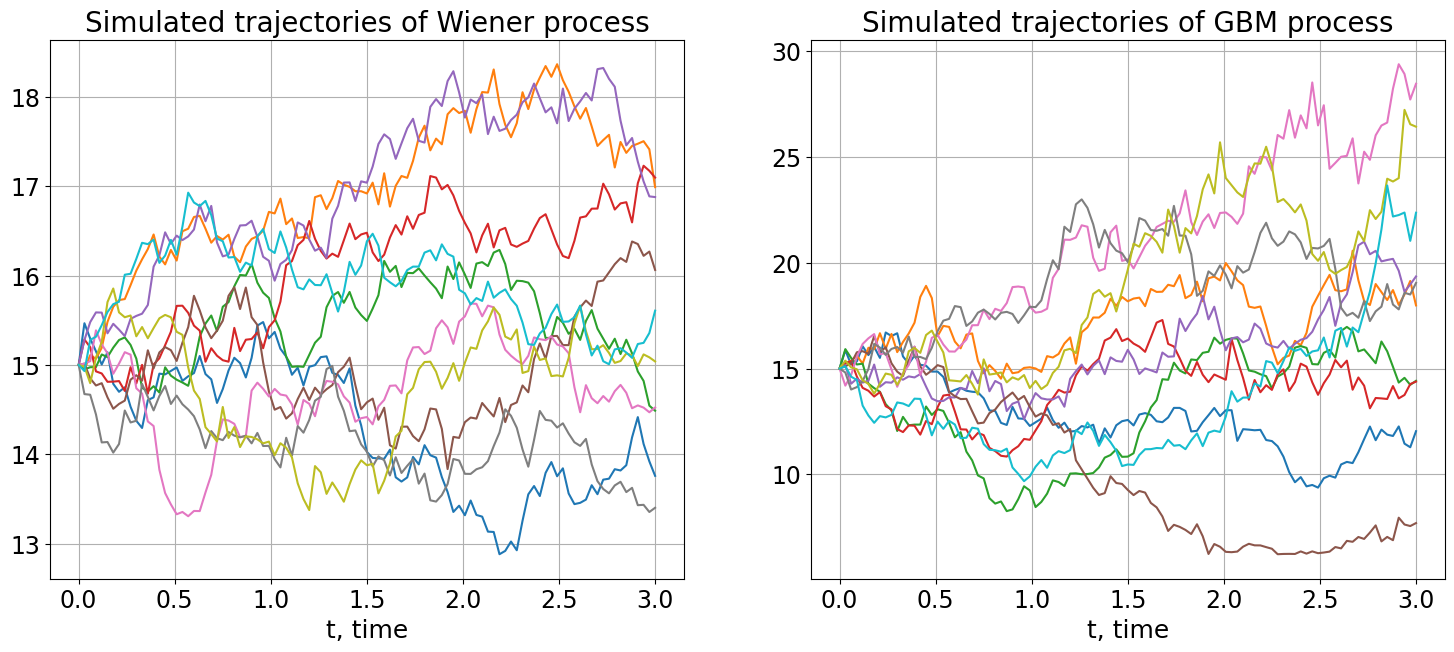

In [55]:
#plots

f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,7))

ax1.grid()
ax1.set_title('Simulated trajectories of Wiener process',fontsize=20)
ax1.set_xlabel('t, time',fontsize=18)
ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax1.plot(ts,wienTrajs[:, 0, :].T)

ax2.grid()
ax2.set_title('Simulated trajectories of GBM process',fontsize=20)
ax2.set_xlabel('t, time',fontsize=18)
ax2.tick_params(axis='x', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)
ax2.plot(ts,gbmTrajs[:, 0, :].T)

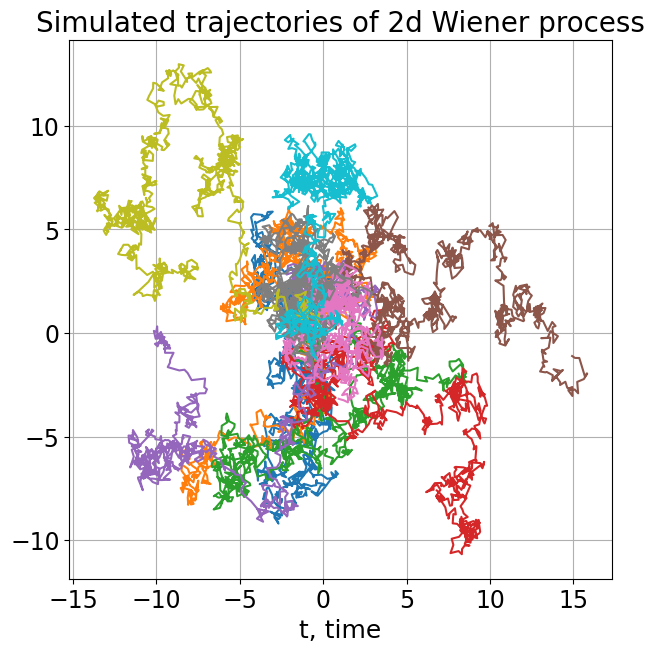

In [56]:
#2D
a = 0
b = 50
Nt = 1000
h = (b-a)/Nt
ts = np.arange(a, b + h/2, h)

Ntraj = 10
x0 = np.zeros([100])

two_d_wien = simulateWienerProcess(x0, ts, Ntraj)

f, ax = plt.subplots(figsize=(7,7))

ax.grid()
ax.set_title('Simulated trajectories of 2d Wiener process',fontsize=20)
ax.set_xlabel('t, time',fontsize=18)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)
ax.plot(two_d_wien[:, 0, :].T, two_d_wien[:, 1, :].T)


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Подгонка параметров GBM под данные

Загрузите датасет gbmData.pkl, который идёт вместе с ноутбуком и попробуйте оценить модель геометрического Броуновского движения для него. Нарисуйте график, на котором указаны точки данных, матожидание полученного процесса и доверительный интервал; пунктиром нарисуйте несколько реализаций процесса геометрического Броуновского движения.

In [8]:
#YOUR CODE
with open('/content/drive/MyDrive/gbmData.pkl', 'rb') as f:
    df = pickle.load(f)

In [9]:
time = df['ts']
prices = df['prices']

In [ ]:
time, prices

In [57]:
model_prices = GBMModel()
model_prices.fit(prices, time)
print(f' Оценка для среднего: {model_prices.mu[0]}, оценка для дрифта: {model_prices.sigma[0]}')

 Оценка для среднего: 0.035700321169935614, оценка для дрифта: 0.16240341752739954


In [22]:
model_prices.simulate

<bound method GBMModel.simulate of <__main__.GBMModel object at 0x7df346461b10>>

In [62]:
Ntraj = 2
a = model_prices.simulate(prices[0]* np.ones([1]), time * np.ones([len(time)]), Ntraj, 0.1)
a.shape

(2, 1, 501)

In [64]:
model_prices.simulate(prices[0]*np.ones([1]), time, 3, 0.1)
simulated_gbm = model_prices.gbmTrajs
expectation = prices[0]*np.exp(model_prices.mu*time)
low = model_prices.interval_low
high = model_prices.interval_high

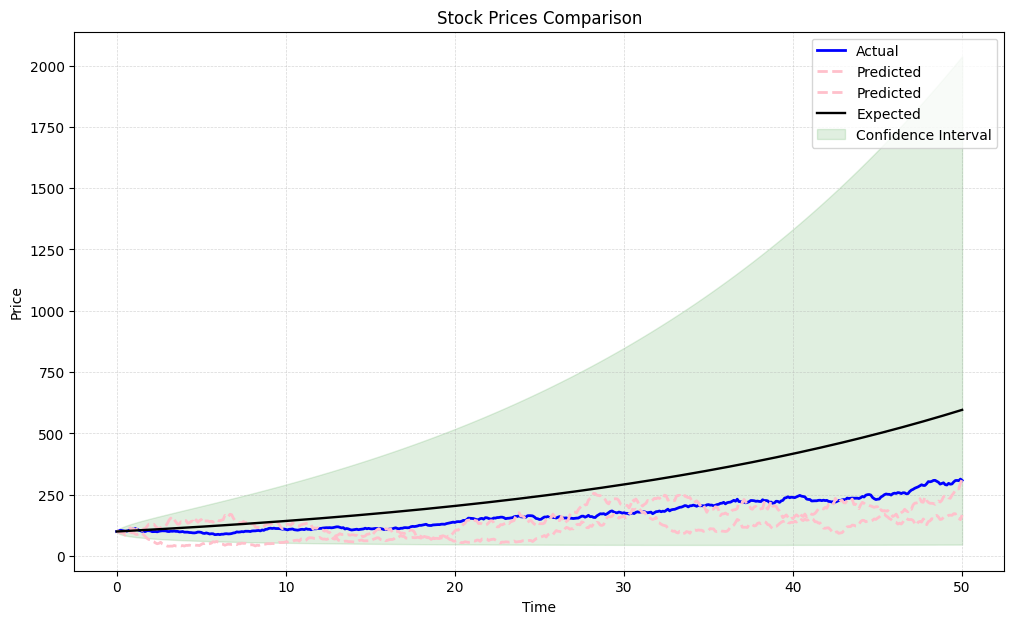

In [69]:
f,ax = plt.subplots(figsize=(12,7))

ax.grid()

ax.plot(time, prices, color = 'blue', linewidth=2, label = 'Actual')
for i in range(Ntraj):
    ax.plot(time, a[i].T, color='pink', linewidth=2, label='Predicted', linestyle = '--')


ax.plot(time, expectation, color = 'black', linewidth=1.7, label = 'Expected')
ax.fill_between(time, low, high, alpha=0.12, color='green', label='Confidence Interval')

ax.set_title('Stock Prices Comparison')
ax.set_xlabel('Time')
ax.set_ylabel('Price')

ax.grid(linestyle='--', linewidth=0.5, alpha=0.5)

ax.legend()

### Проверка качества предсказаний

Проверим, как хорошо делаются предсказания в полученной модели. Для этого обучите модель на первых $60\%$ ряда, а оставшиеся оставьте для тестов. Попробуйте в разных местах обучающей и тестовой части ряда предсказать следующие 50 наблюдений на основе текущего.

Наилучший в смысле среднеквадратической ошибки прогноз -- это условное матожидание

$$
\mathbb{E}[X_{t+h} \vert X_t] = X_t \mathbb{E}[ e^{(\mu - \sigma^2/2)h + \sigma W_h} ].
$$


Процесс Марковский(как увидим позднее), поэтому предыдущая история не важна. Сравните предсказания GBMModel и тестовые значения, нарисуйте доверительные интервалы (можно их построить для прогноза логарифма, а потом взять экспоненту). Насколько модель подходит для короткосрочного и долгосрочного прогноза?

In [70]:
model_pred = GBMModel()
num_obs = int(prices.shape[0]*0.6) # берем 60%
model_pred.fit(prices[:num_obs], time[:num_obs])

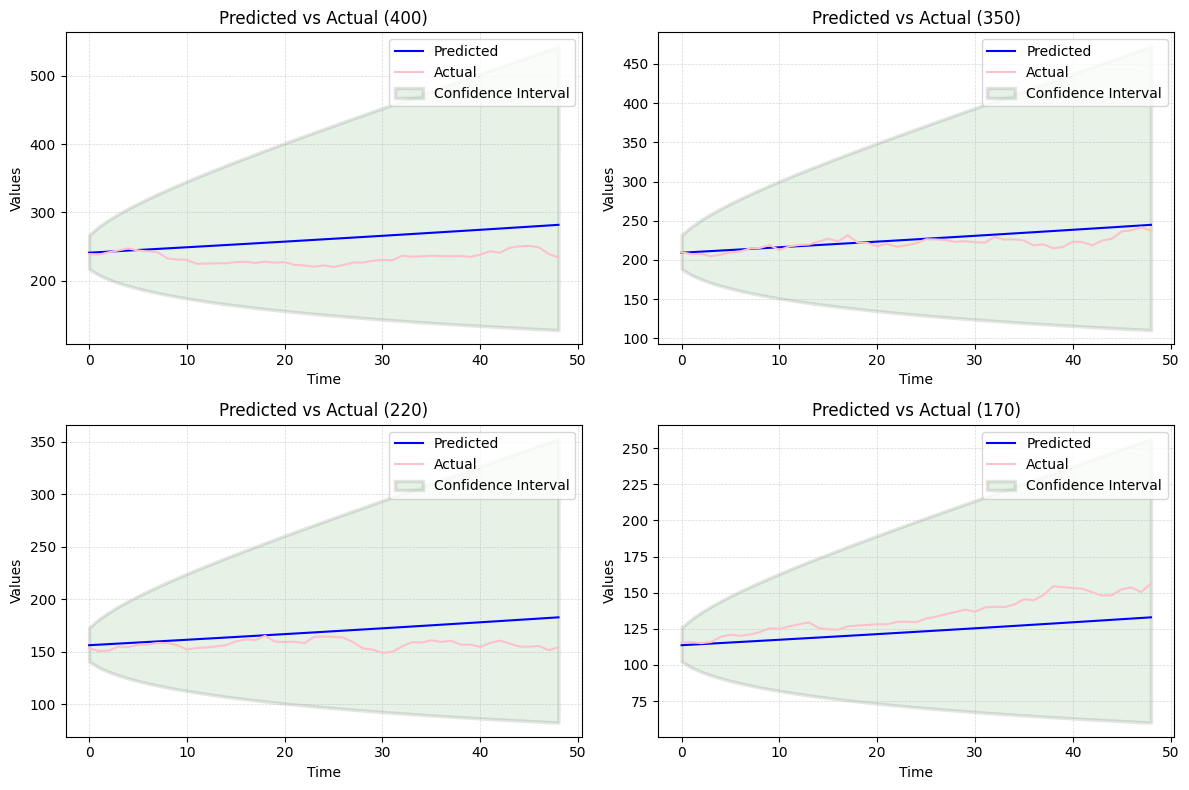

In [74]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for idx, i in enumerate([400, 350, 220, 170]): # старт предсказаний

    start_time = i
    res = model_pred.predict(prices[start_time-1], time[start_time-1:], 50)

    x_values = np.arange(len(res[0]))

    y_predicted = res[0]
    y_actual = prices[start_time:start_time + len(res[0])]

    lower_bound = res[1]
    upper_bound = res[2]

    ax[idx // 2, idx % 2].plot(x_values, y_predicted, label='Predicted', color='blue')
    ax[idx // 2, idx % 2].plot(x_values, y_actual, label='Actual', color='pink')
    ax[idx // 2, idx % 2].fill_between(x_values, lower_bound, upper_bound, alpha=0.1, color='green', label='Confidence Interval', edgecolor='black', linewidth=2.5)

    ax[idx // 2, idx % 2].set_xlabel('Time')
    ax[idx // 2, idx % 2].set_ylabel('Values')
    ax[idx // 2, idx % 2].set_title(f'Predicted vs Actual ({i})')
    ax[idx // 2, idx % 2].grid(True)
    ax[idx // 2, idx % 2].grid(linestyle='--', linewidth=0.5, alpha=0.5)
    ax[idx // 2, idx % 2].legend()

plt.tight_layout()
plt.show()

ВАШ ТЕКСТ И КОММЕНТАРИИ

#### Комментарий

Если говорить о математических и вычислительных аспектах, то можно попробовать задать модель и попробовать её с нуля обучить на своей траектории. Увидим, что в нашей модели есть как минимум одна проблема, которая неочевидна с первого взгляда, но почти сразу возникает на практике. Константная волатильность оценивается очень качественно, но параметр сноса очень неустойчивый. Поэтому если на вход приходит не очень удачная (нередкость)  последовательность наблюдений, то снос оценивать сложнее.